<a href="https://colab.research.google.com/github/TheBlondMyth/AlgoTrading/blob/main/NB4.2_Deep_Hedging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep hedging
---
This notebook gives an example of derivatives hedging using deep learning. The setup is largely the same as NB 4.1. Suppose an agent has sold an option at price $p_0$ which payoff at maturity is $g(S_N)$. The goal is to find the optimal hedging strategy $\phi=(\phi_n)_{n=0,1,...,N}$ to minimise the average squared hedging error $$\inf_{\phi}\mathbb{E}[(X_N-g(S_N))^2]$$ where $$X_N=p_0+\sum_{n=0}^{N-1}\phi_n (S_{n+1}-S_n)$$ with $p_0$ being the premium of the sold option.

We will focus on European call option where $g(S_N)=(S_N-K)^{+}$. Many components of this notebook are identical to those in NB 4.1. Focus on how our loss function is written and how we structure the comparison against the benchmark Black-Scholes delta.

Import several usual libraries.

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as si

np.random.seed(12345) # fix the random seed

We are also going to use the Black-Scholes formula and Delta for call option in our analysis. So let's implement them here as well.

In [ ]:
def BSCallPrice(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r  + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)

def BSCallDelta(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return si.norm.cdf(d1, 0.0, 1.0)

# Generation of random stock price paths

Our stock price process $S=(S_n)_{n=0,1,...,N}$ is given by the value of a geometric Brownian motion sampled at some evenly spaced time intervals over a time horizon of $T$. In particular, $$S_n=s_0\exp\left(\left(\mu-\frac{\sigma^2}{2}\right)t_n+\sigma B_{t_n}\right)$$ where $t_n:=n\Delta t$ with $\Delta t=T/N$ for $n=0,1,...,N$.

The Brownian motion path can be simualted via $$B_{t_n}=\sum_{i=1}^n \epsilon_i \sqrt{\Delta t}$$ where $\epsilon_i\stackrel{\text{i.i.d.}}{\sim} N(0,1)$.

Therefore, an equivalent way to write the process $S$ is
\begin{align}
S_n&=s_0\exp\left(\left(\mu-\frac{\sigma^2}{2}\right)t_n+\sigma B_{t_n}\right)\\
&=s_0\exp\left(\left(\mu-\frac{\sigma^2}{2}\right)n\Delta t+\sigma \sum_{i=1}^n \epsilon_i \sqrt{\Delta t}\right)\\
&=s_0\exp\left(\sum_{i=1}^n\left[\left(\mu-\frac{\sigma^2}{2}\right)\Delta t+\sigma \epsilon_i \sqrt{\Delta t}\right]\right)\\
&=s_0 \exp\left(\sum_{i=1}^n Z_i\right)
\end{align}
where $Z_i\stackrel{\text{i.i.d.}}{\sim} N\left(\left(\mu-\frac{\sigma^2}{2}\right)\Delta t,\sigma^2 \Delta t\right)$. Hence we can simulate the $Z_i$'s and then construct $S_n$ accordingly.

In [ ]:
mu, sigma, T = 0.1, 0.5, 1
s0 = 1

N = 100       # number of trading dates over the time horizon
M = 100000    # number of simulated paths

dt = T / N

# Simulate iid normal random variable with the mean (mu-0.5sigma^2)dt and variance sigma^2 dt.
# Store the values in a M by N matrix
NormalRV = np.random.normal((mu - 0.5 * sigma **2) * dt, sigma * np.sqrt(dt), (M, N))

# Add an extra column of zero as the first column of the matrix NormalRV (for storing the initial stock price s_0)
NormalRV = np.concatenate((np.zeros((M, 1)), NormalRV), axis=1)

# Return the stock price matrix by invoking the formula s_n=s_0* \exp(\sum_i^n Z_i)
S = s0 * np.exp(np.cumsum(NormalRV,axis=1))

Let's look at a few simulated paths where we plot $S_n$ against $t_n$.

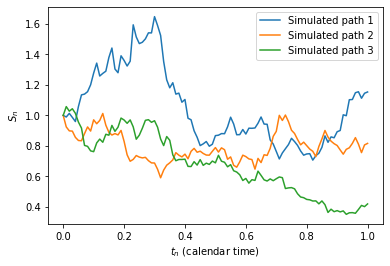

In [ ]:
t = np.linspace(0,T,N+1)

# Just plot 3 paths
for i in range(3):
    plt.plot(t,S[i,:], label="Simulated path "+str(i+1))
plt.xlabel(r"$t_n$ (calendar time)")
plt.ylabel(r"$S_n$")
plt.legend()

# Specification of the neural network

We assume that the hedging strategy only depends on the current time and the current stock price, i.e. $\phi_n=f(n,S_n)$ for some function $f(n,S)$. In contrast to the lecture notes, we will consider $\phi_n=f(t_n,S_n)$ such that it is a function of the calendar time $t_n$ rather than an arbitrary time index $n$. This will allow us to interpret the optimal strategy a bit easier, especially when we compare the results to the Black-Scholes Delta.

We are going to approximate $f$ by a feedforward neural network (FNN). In this example, we will consider a FNN with 3 hidden layers where each of them carries $100$ neurons. The activation functions are relu except that the one at the final layer is an identity function.

An important consideration of our implementation is that we view the information from each simulated path as one single data point, where each path is providing us $2N$ feature values (time and current stock price at $N$ time points). The model should then output the corresponding trading position at each time point, i.e. $$f(t_0,S_0),f(t_1,S_1),...,f(t_{N-1},S_{N-1})$$

We need to structure our neural network such that it accepts an input with shape $(N,2)$ and output a vector with $N$ elements. This can be achieved as follows.

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(100, input_shape=(N,2),activation='relu'))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100, 100)          300       
                                                                 
 dense_1 (Dense)             (None, 100, 100)          10100     
                                                                 
 dense_2 (Dense)             (None, 100, 100)          10100     
                                                                 
 dense_3 (Dense)             (None, 100, 1)            101       
                                                                 
Total params: 20,601
Trainable params: 20,601
Non-trainable params: 0
_________________________________________________________________


# Defining the loss function

Our underlying problem is a quadratic hedging error minimisation problem with call option. Hence we will define our loss function as
\begin{align}
\ell(\boldsymbol{y},\boldsymbol{\hat{y}})&=(p_0+\boldsymbol{y}\cdot \boldsymbol{\hat{y}}-g(s_0+\text{sum}(\boldsymbol{y})))^2\\
&=(p_0+\boldsymbol{y}\cdot \boldsymbol{\hat{y}}-(s_0+\text{sum}(\boldsymbol{y})-K)^{+})^2.
\end{align}
and when training the model we are going to pass the $m^{th}$ actual label as $\boldsymbol{y}^m=(S^m_1-s_0, S^m_2-S^m_1,...,S^m_{N}-S^m_{N-1})$.

Note that $s_0$ in the above definition is a constant which does not depend on which data point we are working with, so we can treat it as some global constant.

One thing which is not too ideal with the code below is that we are passing the option strike level $K$, the initial stock price $s_0$ and the option price to the loss function as some global variables, which in general are poor coding practices. This could probably be avoided if we use some function wrappers but we won't further pursue such ideas here.

In [ ]:
import tensorflow.keras.backend as kb

K = 1 # strike of the call option

# we set the option premium = bs call price
# under this choice we expect the minimised squared hedging error to be zero
bscall = BSCallPrice(s0, K, T, 0, sigma)

def hedge_error_call(y_true, y_pred):
    return (bscall + kb.sum(y_pred * y_true, axis=-1) - kb.maximum(s0 + kb.sum(y_true, axis=-1) - K,0.))**2

# Preparing the training data

The training feature data "xtrain" needs to be a 3D tensor in form of xtrain[m, n, j]. The first index $m\in\{0,1,...,M-1\}$ denotes which data point (simulated path) we are referring to, the second index $n\in\{0,1,...,N-1\}$ is the time index, and the final index $j\in\{0,1\}$ determines whether we refer to the time or the current stock price as the feature. Mathematically, we construct the feature data as
\begin{align}
\text{xtrain}[m,n,j]=
\begin{cases}
t_n=n\Delta t,& j=0\\
S^{m+1}_n,& j=1
\end{cases}
\end{align}

For the label data, it is defined as
	\begin{align*}
	\text{ytrain}=
	\begin{bmatrix}
	S^1_1-S^1_0 & S^1_2-S^1_1 & \cdots & S^1_{N}-S^1_{N-1}\\
	S^2_1-S^2_0 & S^2_2-S^2_1 & \cdots & S^2_{N}-S^2_{N-1}\\
	\vdots & \vdots & \ddots & \vdots\\
	S^M_1-S^M_0 & S^M_2-S^M_1 & \cdots & S^M_{N}-S^M_{N-1}\\
	\end{bmatrix}.
	\end{align*}

In [ ]:
xtrain = np.stack([np.tile(t[0:N], (M, 1)), S[:,0:N]], axis=-1)
ytrain = np.diff(S, axis=1)

print("Shape of xtrain: ", xtrain.shape)
print("Shape of ytrain: ", ytrain.shape)

Shape of xtrain:  (100000, 100, 2)
Shape of ytrain:  (100000, 100)


# Train the model

Now we can train the model which is the easiest part once all the data structures have been handled correctly.

In [ ]:
num_epochs = 15
model.compile(optimizer='adam', loss=hedge_error_call)
r = model.fit(xtrain, ytrain, batch_size=128, epochs=num_epochs)

Epoch 1/15
782/782 [==============================] - 7s 7ms/step - loss: 0.0071
Epoch 2/15
782/782 [==============================] - 6s 7ms/step - loss: 4.0216e-04
Epoch 3/15
782/782 [==============================] - 5s 6ms/step - loss: 4.8359e-04
Epoch 4/15
782/782 [==============================] - 4s 5ms/step - loss: 3.9897e-04
Epoch 5/15
782/782 [==============================] - 4s 5ms/step - loss: 3.8982e-04
Epoch 6/15
782/782 [==============================] - 4s 5ms/step - loss: 3.4274e-04
Epoch 7/15
782/782 [==============================] - 4s 5ms/step - loss: 4.1813e-04
Epoch 8/15
782/782 [==============================] - 4s 5ms/step - loss: 3.5436e-04
Epoch 9/15
782/782 [==============================] - 4s 4ms/step - loss: 3.5489e-04
Epoch 10/15
782/782 [==============================] - 4s 5ms/step - loss: 3.5435e-04
Epoch 11/15
782/782 [==============================] - 4s 5ms/step - loss: 3.4452e-04
Epoch 12/15
782/782 [==============================] - 4s 5ms/step 

Plot the training losses over each epoch.

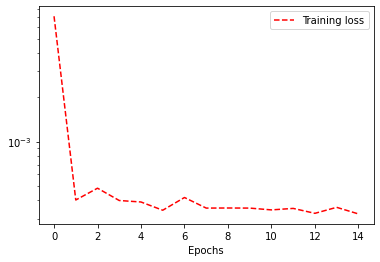

In [ ]:
train_loss = r.history['loss']

ep = range(num_epochs)
plt.plot(ep, train_loss, 'r--', label="Training loss")
plt.xlabel('Epochs')
plt.yscale("log")
plt.legend()

# Properties of the optimal hedging strategy

With the trained neural network, we can study the optimal asset holding $\phi(t,S)$ as a function of current time and stock price. In what follows, we will plot the function of $\phi(t,S)$ against $S$ for different fixed t. Then we will compare the results against the Black-Scholes delta $$\text{BSCallDelta}(T,S)=\frac{\partial}{\partial S}\text{BSCall}(T,S)$$ where $\text{BSCall}(T,S)$ denotes the Black-Scholes call option price with maturity $T$ and spot price $S$. If $N$ is large and $p_0$ is the Black-Scholes price, we expect $\phi(t,S)\approx \text{BSCallDelta}(T-t,S)$.

(Remark: the reason why we use time index $t$ in $\phi$ but $T-t$ in $\text{BSCallDelta}$ is that the $t$ in $\phi(t,S)$ refers to the current time, while the $T$ in $\text{BSCallDelta}(T,S)$ refers to remaining time to maturity. Hence they have to be matched by replacing $T$ by $T-t$ in the delta expression)

The difficult bit of this part is that we need structure the input feature data as a matrix with shape $(N,2)$. We are going structure the data in form of
\begin{align}
\text{xinput}=
\begin{bmatrix}
\bar{t} & s_0\\
\bar{t} & s_1 \\
\bar{t} & s_2 \\
\vdots & \vdots \\
\bar{t} & s_{N-1}
\end{bmatrix}
\end{align}
where $\bar{t}$ is a fixed time point. Then the output of the neural network is a vector with values $\{\phi(\bar{t},s_{n})\}_{n=0,...,N-1}$. This is then plotted together with $\text{BSCallDelta}(T-\bar{t},s_n)$ for different $n$.

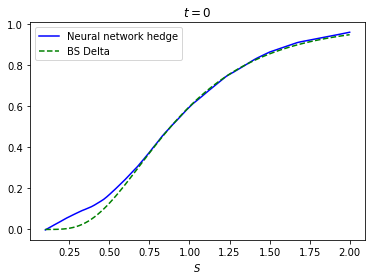

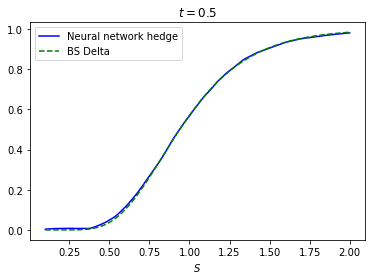

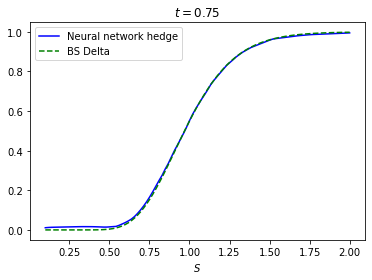

In [ ]:
list_t = [0, 0.5, 0.75]
s_range = np.linspace(0.1, 2, N) # range of S for plotting of \phi(t,s)

for fix_t in list_t:
    X = np.stack([np.ones((1,N))*fix_t, np.reshape(s_range, (1,N))], axis=-1)
    phi = model.predict(X)
    phi = phi.flatten()
    plt.plot(s_range,phi, 'b-', label="Neural network hedge")
    plt.plot(s_range,BSCallDelta(s_range, K, T - fix_t, 0, sigma), 'g--', label="BS Delta")
    plt.title(r'$t=$'+str(fix_t))
    plt.xlabel(r"$S$")
    plt.legend()
    plt.show()

The neural network hedge and the Black-Scholes delta are quite close to each other expect perhaps for extreme stock price levels. It is not surprising because there are not enough data points for very high and very low stock prices so the quality of model fitting will be a bit worse there.